# 4. Captura y procesamiento de imágenes

In [1]:
import skimage as ski
import cv2
import ipywidgets as widgets
import threading
from IPython.display import display, Image

Antes de continuar, es necesario dar permiso a la cámara para que pueda ser
utilizada por Python.
Para ello, usamos el comando `chmod`, que permite cambiar los permisos de un
archivo o directorio (en este caso, de un dispositivo).
Para saber más acerca de esta orden y de por qué usamos el número 666, puedes
consultar la documentación de `chmod` en la terminal con el comando `man chmod`
o bien [este enlace](https://es.wikipedia.org/wiki/Chmod) (spoiler: 666 no tiene
nada que ver con el diablo).

In [2]:
!sudo chmod 666 /dev/video*

A continuación le pedimos a OpenCV que se conecte a la cámara usando la API de
Video for Linux 2 (V4L2); existen otras APIs, pero esta es la más común en
Linux.

In [3]:
dispositivo = cv2.VideoCapture(2, cv2.CAP_V4L2)

Usamos el método `.read()` para capturar un fotograma de la cámara.

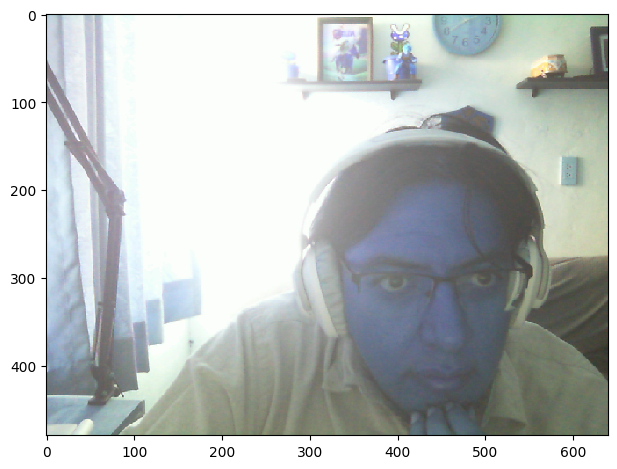

In [4]:
status, cuadro = dispositivo.read()
if not status:
    print("Error al capturar la imagen")
else:
    ski.io.imshow(cuadro)

En el caso de mi cámara, la imagen está en formato BGR (Blue, Green, Red), por
lo que necesitamos convertirla a RGB (Red, Green, Blue) antes de mostrarla.

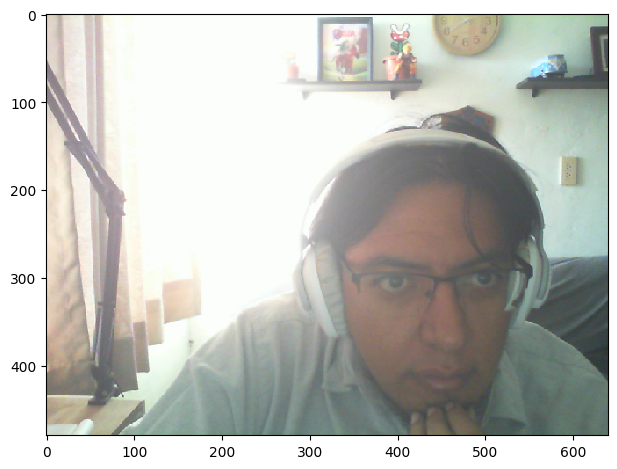

In [5]:
cuadro_rgb = cv2.cvtColor(cuadro, cv2.COLOR_BGR2RGB)
ski.io.imshow(cuadro_rgb)

A partir de aquí, podemos hacer lo que queramos con la imagen, como por ejemplo
detectar los bordes.

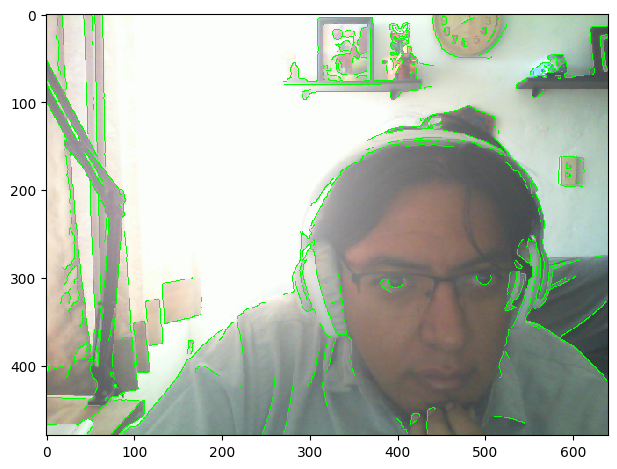

In [6]:
frame_gray = cv2.cvtColor(cuadro, cv2.COLOR_BGR2GRAY)
edges = ski.feature.canny(frame_gray, sigma=1)

# Convertir los bordes a verde
cuadro_rgb[edges] = [0, 255, 0]
ski.io.imshow(cuadro_rgb)

Para cerrar la conexión con la cámara es necesario *liberarla* con el método
`.release()`.

In [7]:
dispositivo.release()

A continuación vamos a diseñar una pequeña interfaz gráfica para poder
capturar video en tiempo real y aplicarle un filtro de detección de bordes.
Nuestra implementación se basa en la biblioteca `ipywidgets`, que nos permite
crear widgets interactivos en un cuaderno de Jupyter.
En una implementación real, podríamos usar una biblioteca como `tkinter`,
`PyQt`, o alguna otra.

Nuestra implementación funciona creando un hilo de ejecución que captura
fotogramas de la cámara y los muestra en un widget de imagen.
Esto nos permite capturar video en tiempo real y aplicarle un filtro sin que
la interfaz gráfica se congele.

In [10]:
boton_detener = widgets.ToggleButton(
    value=False,
    description="Detener",
    disabled=False,
    button_style="danger",
    tooltip="Finalizar la captura de video",
    icon="square",  # Para cambiar el icono por uno de "stop"
)

def conectar_camara(id_camara, ancho=640, alto=480, fps=5):
    # Conectar con la cámara
    dispositivo = cv2.VideoCapture(id_camara, cv2.CAP_V4L2)
    
    # Establecer el tamaño del cuadro de captura
    dispositivo.set(cv2.CAP_PROP_FRAME_WIDTH, ancho)
    dispositivo.set(cv2.CAP_PROP_FRAME_HEIGHT, alto)
    
    # Establecer la tasa de cuadros por segundo
    dispositivo.set(cv2.CAP_PROP_FPS, fps)
    
    return dispositivo

def procesar_imagen(cuadro):
    # Convertir la imagen a escala de grises
    cuadro_gris = cv2.cvtColor(cuadro, cv2.COLOR_BGR2GRAY)
    
    # Aplicar el detector de bordes de Canny
    bordes = cv2.Canny(cuadro_gris, 100, 200)
    
    # Convertir los bordes a color RGB
    cuadro_rgb = cv2.cvtColor(cuadro_gris, cv2.COLOR_GRAY2RGB)
    cuadro_rgb[bordes != 0] = [0, 255, 0]
    
    return cuadro_rgb


def capturar(boton, dispositivo):
    area_salida = display(None, display_id=True)
    salir = False
    while not salir:
        # Capturar y procesar un cuadro de la cámara
        _, cuadro = dispositivo.read()
        cuadro = procesar_imagen(cuadro)

        # Mostrar la imagen resultante en el área de salida
        _, img_jpeg = cv2.imencode(".jpeg", cuadro)
        area_salida.update(Image(data=img_jpeg.tobytes()))    
        
        # Verificar si se ha presionado el botón de detener
        if boton.value:
            dispositivo.release()  # Cerrar la conexión con la cámara
            area_salida.update(None)
            salir = True

dispositivo = conectar_camara(2)
display(boton_detener)
thread = threading.Thread(target=capturar, args=(boton_detener, dispositivo))
thread.start()

ToggleButton(value=False, button_style='danger', description='Detener', icon='square', tooltip='Finalizar la c…

None

Dado que este curso es acerca de procesamiento de imágenes y no de visión por
computadora, no vamos a profundizar más en la detección de bordes u otros
filtros de detección de características.